# **Statistics(I)(2) - Final Project Code**
## **Task 2**

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.libqsturng import qsturng
from statsmodels.stats.multicomp import MultiComparison
from scipy import stats
import seaborn as sns
import math

In [8]:
def shapiro_wilk_test(df, response_col, factor_col, alpha=0.05):
    """
    Runs Shapiro-Wilk test for normality on each group defined by a factor column.

    Parameters:
    - df: pandas DataFrame
    - response_col: Name of the response variable
    - factor_col: Name of the factor variable
    - alpha: Significance level for the Shapiro-Wilk test

    Returns:
    - A dictionary of test results per group
    """
    results = {}
    print(f"Shapiro-Wilk Test for Normality (alpha = {alpha}):\n")

    for level in df[factor_col].unique():
        group_data = df[response_col][df[factor_col] == level]
        stat, p = stats.shapiro(group_data)
        results[level] = {'Shapiro Statistic': stat, 'p-value': p}
        
        print(f"For factor = {level}")
        print(f"  Shapiro statistic = {stat:.6f}, p-value = {p:.6f}", end=" ")
        if p > alpha:
            print("→ Likely Normal")
        else:
            print("→ Not Normal")
    
    return results

In [27]:
def chi_square_normality_test(data, bins=8):
    counts, edges = np.histogram(data, bins=bins)
    mu, sigma = np.mean(data), np.std(data)
    expected_probs = stats.norm.cdf(edges[1:], mu, sigma) - stats.norm.cdf(edges[:-1], mu, sigma)
    expected_counts = expected_probs * len(data)
    expected_counts *= counts.sum() / expected_counts.sum()
    # 卡方檢定
    stat, p = stats.chisquare(f_obs=counts, f_exp=expected_counts)
    return stat, p

In [10]:
def bartlett_test(df, response_col, factor_col, alpha=0.05):
    """
    Performs Bartlett's test for equal variances across groups.

    Parameters:
    - df: pandas DataFrame
    - response_col: Name of the numeric response variable
    - factor_col: Name of the categorical factor variable
    - alpha: Significance level for the test

    Returns:
    - (statistic, p-value)
    """
    groups = df[factor_col].unique()
    data_by_group = [df[response_col][df[factor_col] == group] for group in groups]

    stat, p = stats.bartlett(*data_by_group)
    print("Bartlett’s Test for Equal Variances:")
    print(f"  Test statistic = {stat:.6f}, p-value = {p:.6f}", end=" ")

    if p > alpha:
        print("→ Equal variances assumed")
    else:
        print("→ Variances differ significantly")

    return stat, p

In [11]:
def tukey_hsd(df, response_col, factor_col, alpha=0.05, comparison_focus=None):
    """
    Performs Tukey's HSD test and plots confidence intervals.

    Parameters:
    - df: pandas DataFrame
    - response_col: Dependent variable
    - factor_col: Categorical independent variable
    - alpha: Significance level (default 0.05)
    - comparison_focus: Optional group name to center the plot on

    Returns:
    - Tuple of (summary table, omega)
    """
    group_sizes = df.groupby(factor_col).size()
    k = len(group_sizes)
    df_within = df.shape[0] - k
    
    ng = k / np.sum(1 / group_sizes)

    model = smf.ols(f"{response_col} ~ C({factor_col})", data=df).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    mse = aov_table.loc["Residual", "sum_sq"] / aov_table.loc["Residual", "df"]

    q_crit = qsturng(1 - alpha, k, df_within)
    omega = q_crit * np.sqrt(mse / ng)

    tukey = MultiComparison(df[response_col], df[factor_col])
    tukey_result = tukey.tukeyhsd(alpha=alpha)

    print(f"Q critical value = {q_crit:.6f}")
    print(f"Tukey Omega = {omega:.6f}")
    print(tukey_result.summary())

    _ = tukey_result.plot_simultaneous()
    plt.title("Tukey HSD Confidence Intervals")
    plt.show()

    if comparison_focus:
        _ = tukey_result.plot_simultaneous(comparison_name=comparison_focus)
        plt.title(f"Tukey HSD Focused on: {comparison_focus}")
        plt.show()

    return tukey_result.summary(), omega

In [37]:
df = pd.read_csv("movie_summary.csv")

filtered_df = df[
    (df['production_budget'] != 0) &
    (df['production_year'] > 2000) &
    df['genre'].notna() &
    df['domestic_box_office'].notna() &
    df['international_box_office'].notna()
].copy()
filtered_df["total_box_office"] = filtered_df["domestic_box_office"] + filtered_df["international_box_office"]

filtered_df["flattened_production_budget"] = np.power(filtered_df["production_budget"], 1/4)
filtered_df["flattened_total_box_office"] = np.power(filtered_df["total_box_office"], 1/4)

filtered_df['z_score_bu'] = stats.zscore(filtered_df['production_budget'])
filtered_df['z_score_bo'] = stats.zscore(filtered_df['total_box_office'])
filtered_df = filtered_df[filtered_df['z_score_bu'].abs() <= 2].copy()
filtered_df = filtered_df[filtered_df['z_score_bo'].abs() <= 2].copy()

print("min budget:", filtered_df["production_budget"].min())
print("max budget:", filtered_df["production_budget"].max())
# 預算分4組，每組1000萬
bin_edges = [0, 10_000_000, 20_000_000, 30_000_000, np.inf]
bin_labels = ['0_1000w', '1000_2000w', '2000_3000w', '3000_4000w']
filtered_df['budget_group'] = pd.cut(
    filtered_df['production_budget'],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True
)

target_genres = ['Romantic Comedy', 'Thriller/Suspense', 'Comedy', 'Drama']
filtered_df = filtered_df[filtered_df['genre'].isin(target_genres)]
target_budgets = ['1000_2000w', '2000_3000w', '3000_4000w']
filtered_df = filtered_df[filtered_df['budget_group'].isin(target_budgets)]
filtered_df['group_label'] = (
    filtered_df['budget_group'].astype(str)
    + ' - '
    + filtered_df['genre'].astype(str)
)

min budget: 1100
max budget: 130000000


In [38]:
group_labels = ['3000_4000w - Comedy', '0_1000w - Romantic Comedy', 
 '3000_4000w - Thriller/Suspense', '3000_4000w - Drama', 
 '3000_4000w - Romantic Comedy', '2000_3000w - Romantic Comedy', 
 '2000_3000w - Drama', '2000_3000w - Thriller/Suspense', '0_1000w - Comedy', 
 '1000_2000w - Drama', '1000_2000w - Comedy', '2000_3000w - Comedy',
 '1000_2000w - Thriller/Suspense', '1000_2000w - Romantic Comedy',
 '0_1000w - Drama', '0_1000w - Thriller/Suspense']

print(filtered_df['group_label'].unique())
group_shapes = {label: filtered_df[filtered_df['group_label'] == label].shape for label in group_labels}
print()

display(group_shapes)

variances = {filtered_df["flattened_total_box_office"][filtered_df['group_label'] == label].std(ddof=1) for label in group_labels}
display(variances)

['3000_4000w - Comedy' '3000_4000w - Thriller/Suspense'
 '3000_4000w - Drama' '3000_4000w - Romantic Comedy'
 '2000_3000w - Romantic Comedy' '2000_3000w - Drama'
 '2000_3000w - Thriller/Suspense' '1000_2000w - Drama'
 '1000_2000w - Comedy' '2000_3000w - Comedy'
 '1000_2000w - Thriller/Suspense' '1000_2000w - Romantic Comedy']



{'3000_4000w - Comedy': (186, 30),
 '0_1000w - Romantic Comedy': (0, 30),
 '3000_4000w - Thriller/Suspense': (140, 30),
 '3000_4000w - Drama': (193, 30),
 '3000_4000w - Romantic Comedy': (56, 30),
 '2000_3000w - Romantic Comedy': (32, 30),
 '2000_3000w - Drama': (137, 30),
 '2000_3000w - Thriller/Suspense': (56, 30),
 '0_1000w - Comedy': (0, 30),
 '1000_2000w - Drama': (250, 30),
 '1000_2000w - Comedy': (155, 30),
 '2000_3000w - Comedy': (89, 30),
 '1000_2000w - Thriller/Suspense': (82, 30),
 '1000_2000w - Romantic Comedy': (39, 30),
 '0_1000w - Drama': (0, 30),
 '0_1000w - Thriller/Suspense': (0, 30)}

{nan,
 19.278054582802632,
 19.65256674582338,
 20.888958896355444,
 20.947119901742866,
 21.130396433324062,
 21.345991491159275,
 21.539936695790264,
 22.933945586997655,
 23.16822534546749,
 23.655481457218684,
 23.68493014509021,
 25.396672634882563}

In [31]:


display(filtered_df[filtered_df['group_label'] == '1000_2000w - Comedy'])
for label in group_labels:
    x = filtered_df['flattened_total_box_office'][filtered_df['group_label'] == label]
    # Shapiro-Wilk test
    # Chi-square test
    try:
        c_stat, c_p = chi_square_normality_test(x, 4)
        chi_msg = f"χ² = {c_stat:.4f}, p = {c_p:.4f} → {'常態' if c_p > 0.05 else '不常態'}"
    except ValueError as e:
        chi_msg = f"Chi-square 檢定失敗：{e}"

    print(f"\n預算組別：{label}")
    print(f"Chi-square    : {chi_msg}")


預算組別：3000_4000w - Comedy
Chi-square    : χ² = 1.7522, p = 0.6254 → 常態

預算組別：0_1000w - Romantic Comedy
Chi-square    : χ² = 1.2884, p = 0.7319 → 常態

預算組別：3000_4000w - Thriller/Suspense
Chi-square    : χ² = 1.9875, p = 0.5750 → 常態

預算組別：3000_4000w - Drama
Chi-square    : χ² = 0.7401, p = 0.8637 → 常態

預算組別：3000_4000w - Romantic Comedy
Chi-square    : χ² = 1.7303, p = 0.6302 → 常態

預算組別：2000_3000w - Romantic Comedy
Chi-square    : χ² = 1.5552, p = 0.6696 → 常態

預算組別：2000_3000w - Drama
Chi-square    : χ² = 0.3815, p = 0.9440 → 常態

預算組別：2000_3000w - Thriller/Suspense
Chi-square    : χ² = 2.9398, p = 0.4010 → 常態

預算組別：0_1000w - Comedy
Chi-square    : χ² = 13.0045, p = 0.0046 → 不常態

預算組別：1000_2000w - Drama
Chi-square    : χ² = 1.1357, p = 0.7685 → 常態

預算組別：1000_2000w - Comedy
Chi-square    : χ² = 2.5883, p = 0.4595 → 常態

預算組別：2000_3000w - Comedy
Chi-square    : χ² = 1.3240, p = 0.7234 → 常態

預算組別：1000_2000w - Thriller/Suspense
Chi-square    : χ² = 2.9863, p = 0.3937 → 常態

預算組別：1000_2000w - Roman

In [40]:
# df_clean = filtered_df[filtered_df['group_label'].isin(group_labels)]
bartlett_result = bartlett_test(
    df=filtered_df,
    response_col='flattened_total_box_office',
    factor_col='group_label',
    alpha=0.05
)

Bartlett’s Test for Equal Variances:
  Test statistic = 16.483220, p-value = 0.124118 → Equal variances assumed


If we dump movies with low budget the result would be beautiful. However this impacts others' work a lot so we are struggling.

In [42]:
# excluded 0_1000w
filtered_df['genre'] = filtered_df['genre'].astype('category')
filtered_df['budget_category'] = filtered_df['budget_group'].astype('category')

model = smf.ols(
    'flattened_total_box_office ~ C(genre) + C(budget_group) + C(genre):C(budget_group)',
    data=filtered_df
).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                sum_sq      df             F    PR(>F)
C(genre)                  2.103269e-09     3.0  1.349591e-12  1.000000
C(budget_group)           1.011647e+07     3.0  6.491367e+03  0.000000
C(genre):C(budget_group)  2.153592e+04     9.0  4.606271e+00  0.000005
Residual                  7.288349e+05  1403.0           NaN       NaN


Q critical value = 4.629652
Tukey Omega = 11.855840
                         Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
            group1                         group2             meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------------------------------------------
           1000_2000w - Comedy             1000_2000w - Drama  -9.4558  0.003 -17.0836  -1.828   True
           1000_2000w - Comedy   1000_2000w - Romantic Comedy  -5.0188 0.9866 -18.3851  8.3475  False
           1000_2000w - Comedy 1000_2000w - Thriller/Suspense  -3.9302 0.9834 -14.1187  6.2583  False
           1000_2000w - Comedy            2000_3000w - Comedy   7.3169 0.3972  -2.6061 17.2399  False
           1000_2000w - Comedy             2000_3000w - Drama   3.0882  0.992  -5.6611 11.8375  False
           1000_2000w - Comedy   2000_3000w - Romantic Comedy  15.6128  0.022   1.1254 30.1001   True
           1000_2000w - Comedy

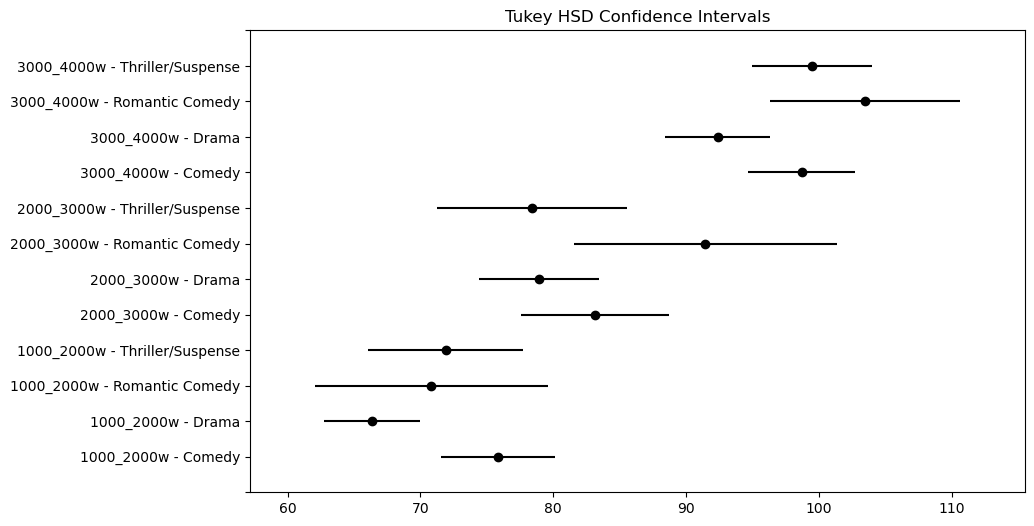

In [43]:
summary, omega = tukey_hsd(
    df=filtered_df,
    response_col='flattened_total_box_office',
    factor_col='group_label',
    alpha=0.05,
    comparison_focus=None
)